# Capstone Project - Car accident severity

## Table of contents
* [1. Introduction: Business Problem](#introduction)
* [2. Data](#data)
* [3. Methodology](#Methodology)
* [4. Results](#result)
* [5. Discussion](#discussion)
* [6. Conclusions](#conclusion)

## 1. Introduction: Business Problem <a name="introduction"></a>

Road traffic crashes are one of the world's largest public health and injury prevention problems. The problem is all the more acute because the victims are overwhelmingly healthy before their crashes. 

According to the World Health Organization (WHO), more than 1 million people are killed on the world's roads each year. A report published by the WHO in 2004 estimated that some 1.2 million people were killed and 50 million injured in traffic collisions on the roads around the world each year and was the leading cause of death among children 10–19 years of age.

The project's objective is to predict the probability and severity of a car accident before it happens in order to intimate the driver to avoid such incidents through the use of historical car accidents data and how aspects like weather, road conditions, traffic and many other factors affect the probability of an accident and how severe it can be.

## 2. Data <a name="data"></a>

### 2.1 Data Description

The data is taken from the Seattle Department of Transportation and recorded by Traffic Records Group. It covers the annual collisions data from 2004 to the present. The dataset can be downloaded from <a href = "https://www.kaggle.com/jonleon/seattle-sdot-collisions-data/download"> here </a>  and the metadata from <a href = "https://www.seattle.gov/Documents/Departments/SDOT/GIS/Collisions_OD.pdf"> here <a/>.

### 2.2 Data Understanding

In [3]:
# importing the required libraries
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import MarkerCluster
from sklearn.model_selection import train_test_split
import warnings
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

In [5]:
# reading the dataset
df = pd.read_csv(r"Kaggle-Collisions-Dataset.csv")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [6]:
df.shape

(221266, 40)

In [7]:
df.columns

Index(['X', 'Y', 'OBJECTID', 'INCKEY', 'COLDETKEY', 'REPORTNO', 'STATUS',
       'ADDRTYPE', 'INTKEY', 'LOCATION', 'EXCEPTRSNCODE', 'EXCEPTRSNDESC',
       'SEVERITYCODE', 'SEVERITYDESC', 'COLLISIONTYPE', 'PERSONCOUNT',
       'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'INJURIES', 'SERIOUSINJURIES',
       'FATALITIES', 'INCDATE', 'INCDTTM', 'JUNCTIONTYPE', 'SDOT_COLCODE',
       'SDOT_COLDESC', 'INATTENTIONIND', 'UNDERINFL', 'WEATHER', 'ROADCOND',
       'LIGHTCOND', 'PEDROWNOTGRNT', 'SDOTCOLNUM', 'SPEEDING', 'ST_COLCODE',
       'ST_COLDESC', 'SEGLANEKEY', 'CROSSWALKKEY', 'HITPARKEDCAR'],
      dtype='object')

The dataset is huge as it consists of 221266 rows and 40 columns.
The scope of the project is to predict the likelihood and severity of an accident. Therefore, we use SEVERITYCODE (i.e. the severity of the accident) as the dependent variable.

We can potentially use the other 39 columns to train the algorithm. 
There are many columns that are not relevant for this project or they contain non-standardized data and missing values hence the data needs to be cleaned up.

In [8]:
temp = df[["SEVERITYCODE","SEVERITYDESC"]]
temp.value_counts().to_frame()

,,0
SEVERITYCODE,SEVERITYDESC,
1,Property Damage Only Collision,137485
2,Injury Collision,58698
0,Unknown,21635
2b,Serious Injury Collision,3098
3,Fatality Collision,349


### 2.3 Data Preparation

In [8]:
df['SEVERITYDESC'].value_counts().to_frame()

,SEVERITYDESC
Property Damage Only Collision,137485
Injury Collision,58698
Unknown,21636
Serious Injury Collision,3098
Fatality Collision,349


In order to prepare the data for the further stages, the unnecessary columns will be dropped and columns having missing data will be handled.

### 2.3.1 Unnecessary Columns

Unique Keys are not predictors and will be dropped.

('OBJECTID','INTKEY','COLDETKEY','INCKEY','SEGLANEKEY','CROSSWALKKEY')

There is no description of some columns in the dataset and needs to dropped. 

('EXCEPTRSNCODE', 'REPORTNO', 'STATUS', 'SDOTCOLNUM','ST_COLCODE','PEDROWNOTGRNT')

The desciption columns don't serve any purpose for this project and will be dropped.

('EXCEPTRSNDESC', 'SEVERITYDESC', 'SDOT_COLDESC', 'ST_COLDESC')

In [8]:
# Dropping above mentioned columns
df_da = df.drop(['OBJECTID','INTKEY','COLDETKEY','REPORTNO','INCKEY','STATUS','EXCEPTRSNCODE','EXCEPTRSNDESC','SEVERITYDESC','PEDROWNOTGRNT','SDOTCOLNUM','ST_COLDESC','ST_COLCODE','SEGLANEKEY','CROSSWALKKEY','SDOT_COLDESC'],axis=1)

In [9]:
df_da.shape

(221266, 24)

In [10]:
df_da.head(2)

,X,Y,ADDRTYPE,LOCATION,SEVERITYCODE,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INJURIES,SERIOUSINJURIES,FATALITIES,INCDATE,INCDTTM,JUNCTIONTYPE,SDOT_COLCODE,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,SPEEDING,HITPARKEDCAR
0,-122.386772,47.564720,Intersection,CALIFORNIA AVE SW AND SW GENESEE ST,2,Pedestrian,2,1,0,1,1,0,0,2019/11/20 00:00:00+00,11/20/2019 10:25:00 AM,At Intersection (intersection related),24.0,NaN,N,Clear,Dry,Daylight,NaN,N
1,-122.341806,47.686934,Intersection,STONE AVE N AND N 80TH ST,2,Angles,4,0,0,2,2,0,0,2019/11/18 00:00:00+00,11/18/2019 5:01:00 PM,At Intersection (intersection related),11.0,NaN,N,Raining,Wet,Dark - Street Lights On,NaN,N


The dataset "df_da" holds all the features that will be analyzed.

### 2.3.2 Evaluating for Missing Data

Checking for null values in the dataset.


In [12]:
df_da.isnull().sum().to_frame()

,0
X,7469
Y,7469
ADDRTYPE,3712
LOCATION,4586
SEVERITYCODE,1
COLLISIONTYPE,26499
PERSONCOUNT,0
PEDCOUNT,0
PEDCYLCOUNT,0
VEHCOUNT,0


As displayed, the dataset has a lot of null values which needs to be deleted or replaced.

### 2.3.3 Dealing with missing data

#### SPEEDING, INATTENTIONIND, UNDERINFL, HITPARKEDCAR

In [13]:
df_da['SPEEDING'].value_counts().to_frame()

,SPEEDING
Y,9913


In [14]:
df_da['INATTENTIONIND'].value_counts().to_frame()

,INATTENTIONIND
Y,30188


In [15]:
df_da['UNDERINFL'].value_counts().to_frame()

,UNDERINFL
N,103482
0,81676
Y,5399
1,4230


In [16]:
df_da['HITPARKEDCAR'].value_counts().to_frame()

,HITPARKEDCAR
N,209290
Y,11976


In [17]:
#Replacing null values with 0 and Y with 1
df_da['SPEEDING'].replace(np.nan, 0, inplace=True)
df_da['SPEEDING'].replace('Y', 1, inplace=True)
df_da['INATTENTIONIND'].replace(np.nan,0,inplace=True)
df_da['INATTENTIONIND'].replace('Y', 1, inplace=True)
#Replacing Y and N values with 0 and 1
df_da['UNDERINFL'].replace(to_replace={'Y':1, 'N':0, '1':1, '0':0}, inplace=True)
df_da['UNDERINFL'].replace(np.nan,"0",inplace=True)
df_da['UNDERINFL'].replace(to_replace={'Y':1, 'N':0, '1':1, '0':0}, inplace=True)
df_da['UNDERINFL'].replace(to_replace={1.0 :1,0.0:0}, inplace=True)
df_da['HITPARKEDCAR'].replace(to_replace={'Y':1, 'N':0}, inplace=True)

In [18]:
df_da['SPEEDING'].value_counts().to_frame()

,SPEEDING
0,211353
1,9913


In [19]:
df_da['INATTENTIONIND'].value_counts().to_frame()

,INATTENTIONIND
0,191078
1,30188


In [20]:
df_da['UNDERINFL'].value_counts().to_frame()

,UNDERINFL
0,211637
1,9629


In [21]:
df_da['HITPARKEDCAR'].value_counts().to_frame()

,HITPARKEDCAR
0,209290
1,11976


### 2.3.4 Unknown and Other values

Many features have Unknown and Other values which are of no use and needs to removed.

SEVERITYCODE

In [22]:
df_da['SEVERITYCODE'].value_counts().to_frame()

,SEVERITYCODE
1,137485
2,58698
0,21635
2b,3098
3,349


The value 0 is for unknown.

In [23]:
# Replacing with null
df_da['SEVERITYCODE'].replace("0",np.nan,inplace=True)

In [24]:
# Replacing values 3 with 4 and 2b with 3
df_da['SEVERITYCODE'].replace('3', '4', inplace=True)
df_da['SEVERITYCODE'].replace('2b', '3', inplace=True)

In [25]:
df_da['SEVERITYCODE'].value_counts().to_frame()

,SEVERITYCODE
1,137485
2,58698
3,3098
4,349


Replcing all Unknown and Oher values with null.

In [26]:

df_da.replace(to_replace={'Unknown': np.nan, 
                        'Other':np.nan}, inplace=True)

Dropping all the null values.

In [27]:
df_da.dropna(inplace=True)

In [28]:
df_da.isnull().sum().to_frame()

,0
X,0
Y,0
ADDRTYPE,0
LOCATION,0
SEVERITYCODE,0
COLLISIONTYPE,0
PERSONCOUNT,0
PEDCOUNT,0
PEDCYLCOUNT,0
VEHCOUNT,0


### 2.3.5 Date-Time Features

Extracting Months, Days and Hours from Date-Time variables

In [29]:
# Convert INCDTTM to date type

df_da['INCDTTM'] = pd.to_datetime(df_da['INCDTTM'], errors='coerce')

# Extract month, weekday, hour information

df_da['Month']=df_da['INCDTTM'].dt.month
df_da['Weekday']=df_da['INCDTTM'].dt.weekday
df_da['Hour']=df_da['INCDTTM'].dt.hour

In [30]:
# Dropping unnecessary features
df_da.drop(['INCDATE', 'INCDTTM'], axis=1, inplace=True)

In [31]:
df_da.shape

(147743, 25)

## 3. Methodology <a name="methodology"></a>

### 3.1 Exploratory Data Analysis

Using X and Y features to visualize the areas where collsions took place.

In [11]:
map = folium.Map(location=[47.606209, -122.332069], zoom_start=11)
map_clust = MarkerCluster().add_to(map)
location = df_da[['Y', 'X']][df_da['Y'].notnull()][:5000]
loc = location.values.tolist()
for i in range(len(loc)):
  folium.Marker(loc[i]).add_to(map_clust)
map

Analyzing Addr Type

In [33]:
df_da['ADDRTYPE'].value_counts().to_frame()

,ADDRTYPE
Block,88304
Intersection,59439


<AxesSubplot:xlabel='ADDRTYPE', ylabel='count'>

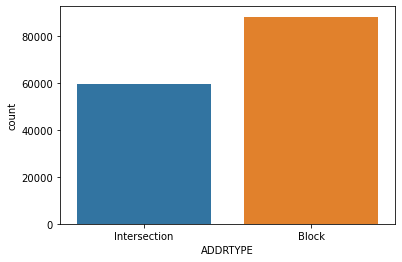

In [32]:
sns.countplot(df_da['ADDRTYPE'], data=df_da)

Analyzing Severity Code

In [33]:
df_da['SEVERITYCODE'].value_counts().to_frame()

,SEVERITYCODE
1,95665
2,49404
3,2434
4,240


<AxesSubplot:xlabel='SEVERITYCODE', ylabel='count'>

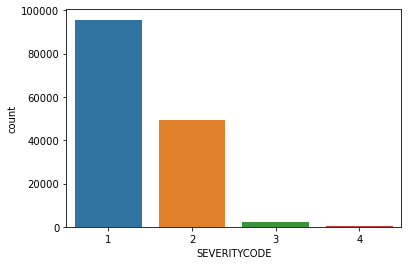

In [34]:
sns.countplot(df_da['SEVERITYCODE'], data=df_da)

Analyzing Collision Type

In [35]:
df_da['COLLISIONTYPE'].value_counts().to_frame()

,COLLISIONTYPE
Angles,34360
Parked Car,32684
Rear Ended,32050
Sideswipe,17260
Left Turn,13638
Pedestrian,7229
Cycles,5634
Right Turn,2823
Head On,2065


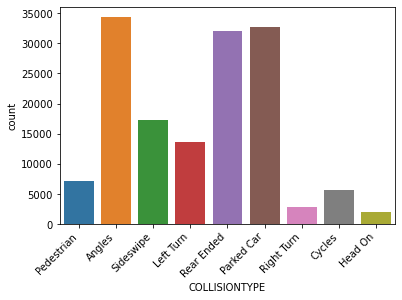

In [36]:
ax = sns.countplot(df_da['COLLISIONTYPE'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

Analyzing Junction Type

In [37]:
df_da['JUNCTIONTYPE'].value_counts().to_frame()

,JUNCTIONTYPE
Mid-Block (not related to intersection),63572
At Intersection (intersection related),57851
Mid-Block (but intersection related),18169
Driveway Junction,6475
At Intersection (but not related to intersection),1564
Ramp Junction,112


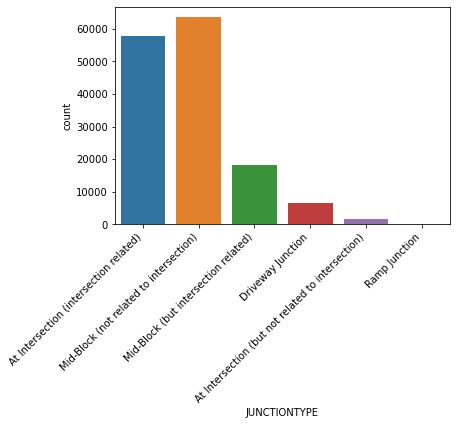

In [38]:
ax = sns.countplot(df_da['JUNCTIONTYPE'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

Analyzing Weather

In [39]:
df_da['WEATHER'].value_counts().to_frame()

,WEATHER
Clear,95983
Raining,27376
Overcast,23186
Snowing,631
Fog/Smog/Smoke,424
Sleet/Hail/Freezing Rain,81
Blowing Sand/Dirt,39
Severe Crosswind,16
Partly Cloudy,7


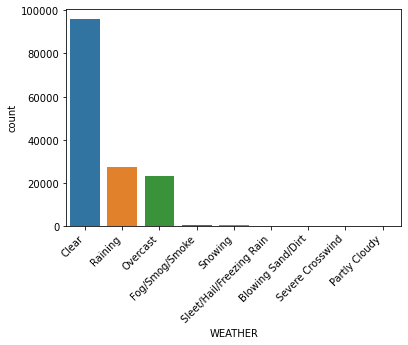

In [40]:
ax = sns.countplot(df_da['WEATHER'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

Analyzing Road Condition

In [41]:
df_da['ROADCOND'].value_counts().to_frame()

,ROADCOND
Dry,107351
Wet,38961
Ice,694
Snow/Slush,635
Standing Water,51
Sand/Mud/Dirt,30
Oil,21


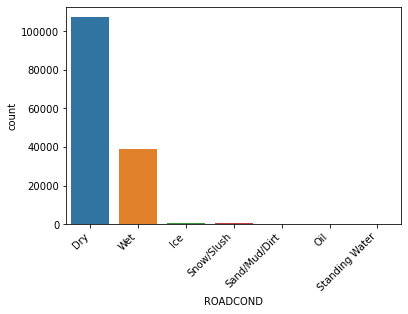

In [42]:
ax = sns.countplot(df_da['ROADCOND'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

Analyzing Light Condition

In [43]:
df_da['LIGHTCOND'].value_counts().to_frame()

,LIGHTCOND
Daylight,100325
Dark - Street Lights On,38437
Dusk,5004
Dawn,1999
Dark - No Street Lights,1055
Dark - Street Lights Off,911
Dark - Unknown Lighting,12


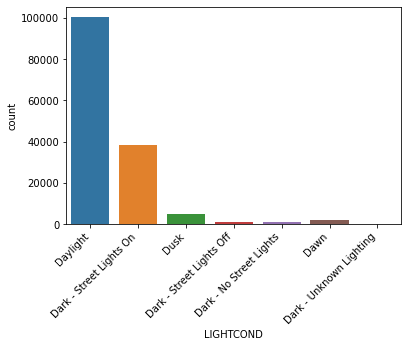

In [44]:
ax = sns.countplot(df_da['LIGHTCOND'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

Analyzing Speeding, Inattention and UnderInfluence

array([<AxesSubplot:ylabel='INATTENTIONIND'>], dtype=object)

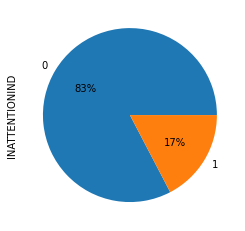

In [45]:
df_da["INATTENTIONIND"].value_counts(normalize=True).plot.pie(subplots=True, autopct='%1.0f%%')

array([<AxesSubplot:ylabel='SPEEDING'>], dtype=object)

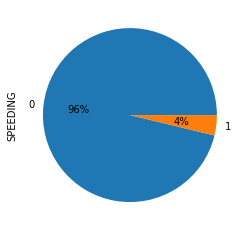

In [46]:
df_da["SPEEDING"].value_counts(normalize=True).plot.pie(subplots=True, autopct='%1.0f%%')

array([<AxesSubplot:ylabel='UNDERINFL'>], dtype=object)

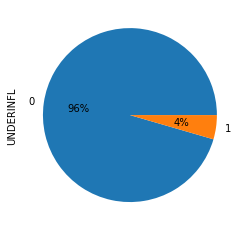

In [47]:
df_da["UNDERINFL"].value_counts(normalize=True).plot.pie(subplots=True, autopct='%1.0f%%')

Analyzing Data-Time Features

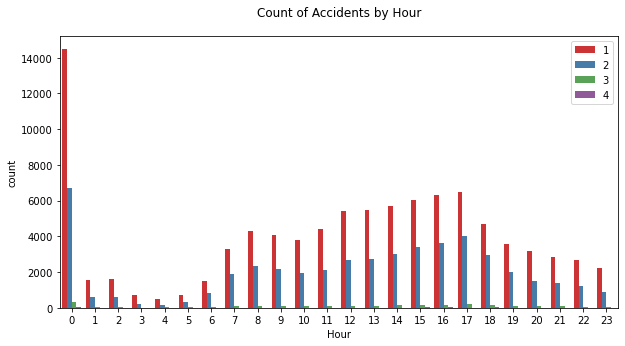

In [48]:
plt.figure(figsize=(10,5))
sns.countplot(x='Hour', hue='SEVERITYCODE', data=df_da, palette="Set1")
plt.legend(loc='best', prop={'size': 10})
plt.title('Count of Accidents by Hour', y=1.05)
plt.show()

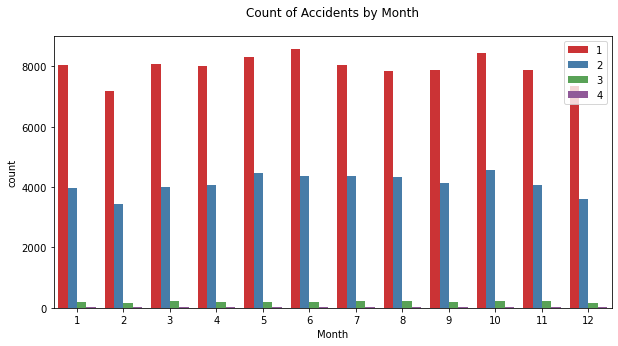

In [49]:
plt.figure(figsize=(10,5))
sns.countplot(x='Month', hue='SEVERITYCODE', data=df_da, palette="Set1")
plt.legend(loc='best', prop={'size': 10})
plt.title('Count of Accidents by Month', y=1.05)
plt.show()

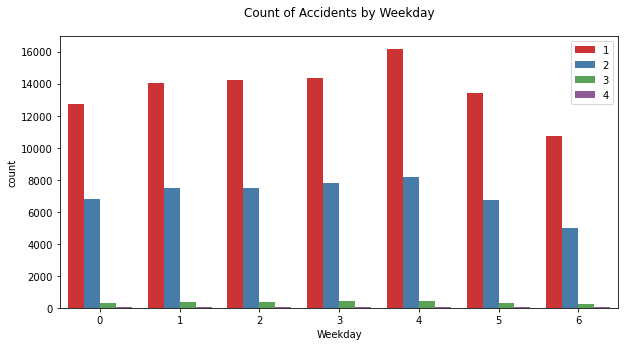

In [50]:
plt.figure(figsize=(10,5))
sns.countplot(x='Weekday', hue='SEVERITYCODE', data=df_da, palette="Set1")
plt.legend(loc='best', prop={'size': 10})
plt.title('Count of Accidents by Weekday', y=1.05)
plt.show()

In [51]:
df_da.columns

Index(['X', 'Y', 'ADDRTYPE', 'LOCATION', 'SEVERITYCODE', 'COLLISIONTYPE',
       'PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'INJURIES',
       'SERIOUSINJURIES', 'FATALITIES', 'JUNCTIONTYPE', 'SDOT_COLCODE',
       'INATTENTIONIND', 'UNDERINFL', 'WEATHER', 'ROADCOND', 'LIGHTCOND',
       'SPEEDING', 'HITPARKEDCAR', 'Month', 'Weekday', 'Hour'],
      dtype='object')

HeatMap to visualize the correlation between features

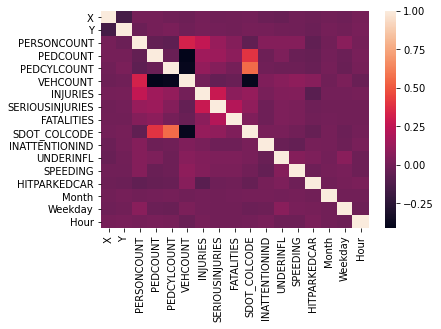

In [52]:
sns.heatmap(df_da.corr())
plt.show()

### 3.2 Feature Selection

In [53]:
df_da.shape

(147743, 25)

The following features are selected on the basis of the analysis:
1. 'JUNCTIONTYPE'
2. 'PERSONCOUNT'
3. 'VEHCOUNT'
4. 'ADDRTYPE'
5. 'PEDCOUNT'
6. 'COLLISIONTYPE'

In [54]:
Feature = df_da[['JUNCTIONTYPE','PERSONCOUNT','VEHCOUNT','ADDRTYPE','PEDCOUNT','COLLISIONTYPE']]

Converting categorical features into n=binary values using One Hot Encoding.

In [55]:
Feature = pd.concat([Feature,pd.get_dummies(df_da['ADDRTYPE'])], axis=1)
Feature = pd.concat([Feature,pd.get_dummies(df_da['JUNCTIONTYPE'])], axis=1)
Feature = pd.concat([Feature,pd.get_dummies(df_da['COLLISIONTYPE'])], axis=1)
Feature.drop(['JUNCTIONTYPE','ADDRTYPE','COLLISIONTYPE'], axis = 1,inplace=True)

In [56]:
X = Feature.values
X[:5]

array([[2, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [4, 2, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [4, 3, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [2, 2, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [2, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]])

In [57]:
y = df_da['SEVERITYCODE'].values

Standardization

In [58]:
X = preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


array([[-0.43981094, -1.90924204,  4.00786249, -1.21886173,  1.21886173,
        -0.10343699,  1.24653675, -0.21409079, -0.37446099, -0.86906387,
        -0.02754357, -0.55049402, -0.19911209, -0.11905922, -0.31889878,
        -0.53297557,  4.40880292, -0.52633285, -0.13956974, -0.36370011],
       [ 0.98494815, -0.07772686, -0.22595773, -1.21886173,  1.21886173,
        -0.10343699,  1.24653675, -0.21409079, -0.37446099, -0.86906387,
        -0.02754357,  1.81655016, -0.19911209, -0.11905922, -0.31889878,
        -0.53297557, -0.22681894, -0.52633285, -0.13956974, -0.36370011],
       [ 0.98494815,  1.75378831, -0.22595773,  0.82043761, -0.82043761,
        -0.10343699, -0.80222264, -0.21409079, -0.37446099,  1.15066342,
        -0.02754357, -0.55049402, -0.19911209, -0.11905922, -0.31889878,
        -0.53297557, -0.22681894, -0.52633285, -0.13956974,  2.74951802],
       [-0.43981094, -0.07772686, -0.22595773, -1.21886173,  1.21886173,
        -0.10343699,  1.24653675, -0.21409079, -

## 3.3 Train-Test Split

Splitting the dataset for training and testing.

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (73871, 20) (73871,)
Test set: (73872, 20) (73872,)


## 3.4 Predictive Modeling

### 1. Decision Tree Classifier

In [99]:
tree_train = DecisionTreeClassifier(criterion="entropy", max_depth = 6)
tree_train.fit(X_train,y_train)
tree_train

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [100]:
tree_predict = tree_train.predict(X_test)
tree_predict

array(['1', '1', '1', ..., '1', '1', '1'], dtype=object)

### 2. K- Nearest Neighbour

Finding the best value of K

In [94]:
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    #Train Model and Predict  
    knn_train = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    knn_predict=knn_train.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, knn_predict)
    std_acc[n-1]=np.std(knn_predict==y_test)/np.sqrt(knn_predict.shape[0])
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

The best accuracy was with 0.7085093134069742 with k= 8


### 3. Logistic Regression

In [62]:
LR_train = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
LR_train

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [63]:
LR_predict = LR_train.predict(X_test)
LR_predict

array(['1', '1', '1', ..., '1', '1', '1'], dtype=object)

In [64]:
LR_prob = LR_train.predict_proba(X_test)
LR_prob

array([[0.91619436, 0.06813467, 0.00901728, 0.00665369],
       [0.61341695, 0.36405736, 0.01560733, 0.00691836],
       [0.87483421, 0.11057951, 0.00792168, 0.00666459],
       ...,
       [0.62174029, 0.35039442, 0.02028882, 0.00757647],
       [0.60502258, 0.37556745, 0.01268662, 0.00672335],
       [0.56038506, 0.42296356, 0.01014923, 0.00650215]])

### 4. Support Vector Machine

In [67]:
SVM_Train = svm.SVC(kernel='rbf')
SVM_Train.fit(X_train, y_train)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [69]:
SVM_predict = SVM_Train.predict(X_test)
SVM_predict

array(['1', '1', '1', ..., '1', '1', '1'], dtype=object)

## 3.5 Model Evaluation

### 1. Evaluating Decision Trees

In [101]:
print("Decision Tree Jaccard index: %.2f" % jaccard_similarity_score(y_test, tree_predict))
print("Decision Tree F1-score: %.2f" % f1_score(y_test, tree_predict, average='weighted') )
print("Decision Tree Accuracy: %.2f" % metrics.accuracy_score(y_test, tree_predict))

Decision Tree Jaccard index: 0.72
Decision Tree F1-score: 0.67
Decision Tree Accuracy: 0.72


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [102]:
print('Confusion Martix:')
print(confusion_matrix(y_test, tree_predict))
print('')
print('Classification Report:')
print (classification_report(y_test, tree_predict))

Confusion Martix:
[[45263  2486     1     0]
 [16978  7775     2     0]
 [  515   730     0     0]
 [   34    88     0     0]]

Classification Report:


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           1       0.72      0.95      0.82     47750
           2       0.70      0.31      0.43     24755
           3       0.00      0.00      0.00      1245
           4       0.00      0.00      0.00       122

   micro avg       0.72      0.72      0.72     73872
   macro avg       0.36      0.32      0.31     73872
weighted avg       0.70      0.72      0.67     73872



### 2. Evaluating KNN

In [105]:
print("KNN Jaccard index: %.2f" % jaccard_similarity_score(y_test, knn_predict))
print("KNN F1-score: %.2f" % f1_score(y_test, knn_predict, average='weighted') )
print("KNN Accuracy: %.2f" % metrics.accuracy_score(y_test, knn_predict))

KNN Jaccard index: 0.70
KNN F1-score: 0.67
KNN Accuracy: 0.70


In [106]:
print('Confusion Martix:')
print(confusion_matrix(y_test, knn_predict))
print('')
print('Classification Report:')
print (classification_report(y_test, knn_predict))

Confusion Martix:
[[43100  4650     0     0]
 [15787  8968     0     0]
 [  473   772     0     0]
 [   27    95     0     0]]

Classification Report:
              precision    recall  f1-score   support

           1       0.73      0.90      0.80     47750
           2       0.62      0.36      0.46     24755
           3       0.00      0.00      0.00      1245
           4       0.00      0.00      0.00       122

   micro avg       0.70      0.70      0.70     73872
   macro avg       0.34      0.32      0.32     73872
weighted avg       0.68      0.70      0.67     73872



### 3. Evaluating Logistic Regression

In [97]:
print("Logistic Regression Jaccard index: %.2f" % jaccard_similarity_score(y_test, LR_predict))
print("Logistic Regression F1-score: %.2f" % f1_score(y_test, LR_predict, average='weighted') )
print("Logistic Regression Accuracy: %.2f" % metrics.accuracy_score(y_test, LR_predict))
print ("LogLoss: : %.2f" % log_loss(y_test, LR_prob))

Logistic Regression Jaccard index: 0.72
Logistic Regression F1-score: 0.68
Logistic Regression Accuracy: 0.72
LogLoss: : 0.60


In [98]:
print('Confusion Martix:')
print(confusion_matrix(y_test, LR_predict))
print('')
print('Classification Report:')
print (classification_report(y_test, LR_predict))

Confusion Martix:
[[44751  2999     0     0]
 [16481  8274     0     0]
 [  509   736     0     0]
 [   30    92     0     0]]

Classification Report:


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           1       0.72      0.94      0.82     47750
           2       0.68      0.33      0.45     24755
           3       0.00      0.00      0.00      1245
           4       0.00      0.00      0.00       122

   micro avg       0.72      0.72      0.72     73872
   macro avg       0.35      0.32      0.32     73872
weighted avg       0.70      0.72      0.68     73872



### 4. Evaluating SVM

In [103]:
print("SVM Jaccard index: %.2f" % jaccard_similarity_score(y_test, SVM_predict))
print("SVM F1-score: %.2f" % f1_score(y_test, SVM_predict, average='weighted') )
print("SVM Accuracy: %.2f" % metrics.accuracy_score(y_test, SVM_predict))

SVM Jaccard index: 0.72
SVM F1-score: 0.68
SVM Accuracy: 0.72


In [104]:
print('Confusion Martix:')
print(confusion_matrix(y_test, SVM_predict))
print('')
print('Classification Report:')
print (classification_report(y_test, SVM_predict))

Confusion Martix:
[[45162  2588     0     0]
 [16816  7939     0     0]
 [  509   736     0     0]
 [   31    91     0     0]]

Classification Report:
              precision    recall  f1-score   support

           1       0.72      0.95      0.82     47750
           2       0.70      0.32      0.44     24755
           3       0.00      0.00      0.00      1245
           4       0.00      0.00      0.00       122

   micro avg       0.72      0.72      0.72     73872
   macro avg       0.36      0.32      0.31     73872
weighted avg       0.70      0.72      0.68     73872



# 4. Results <a name="results"></a>

On examing the scores, the confusion matrix and the classification report. The results of the models are close but the __SVM Model__ is the best among all with an overall Accuracy of __72%__. The model is a really good predictor of Severity 1 collions but the accuracy drastically drops for Severity 2 and none of the models is able to predict for Severity 3 and 4. Since, Severity 2 should be given more preference because of the bigger impact in that case the KNN Model does a great job. Although, the overall accuracy is slightly lower that other models but shows the max number of True Positives ie. 8968 for severity 2 collsions.

# 5. Discussion <a name="discussion"></a>

In my analysis I found that fetures such as INJURIES are really overpowering and on including them the accuracy of models goes to about 96%.
Correlation does not imply causation:
It was found that majority of collision happened in Clear weather, Dry Road, Daylight Light Condition that does not mean that these conditions caused more accidents. In a year majority of days have
1. Clear skies
2. Dry Roads
3. More traffic in day time.
That's the reason why they result to majority of collisions, they do share a correlation but are not the cause of collsions and on including these features the accuracy of the model drops.

Recommendation:

The data is really skewed and majority of features have 1 or 2 values with really high proportion of the whole feature.

# 6. Conclusion <a name="conclusion"></a>

Thanks for reading till the end. This was my first project and I would really appreciate any feedback.